In [2]:

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import xarray as xr
import glob
from contextlib import contextmanager
from tqdm import tqdm
@contextmanager
def cd(newdir):
    prevdir = os.getcwd()
    os.chdir(newdir)
    try:
        yield
    finally:
        os.chdir(prevdir)


model_path = '../SSMIS/F17'

import sys
if sys.path[-1] != model_path:
    sys.path.append(model_path)
import local_functions
import model_operations
import sensor_info


In [8]:
flist = glob.glob(f'/edata2/spencer/rfi_prediction/from_Jackson/1C.F17.SSMIS.*.HDF5'); flist.sort()
flist

['/edata2/spencer/rfi_prediction/from_Jackson/1C.F17.SSMIS.XCAL2021-V.20150805-S215642-E233835.045155.V07A.HDF5',
 '/edata2/spencer/rfi_prediction/from_Jackson/1C.F17.SSMIS.XCAL2021-V.20150805-S233836-E012030.045156.V07A.HDF5',
 '/edata2/spencer/rfi_prediction/from_Jackson/1C.F17.SSMIS.XCAL2021-V.20150806-S012031-E030224.045157.V07A.HDF5',
 '/edata2/spencer/rfi_prediction/from_Jackson/1C.F17.SSMIS.XCAL2021-V.20150806-S030225-E044418.045158.V07A.HDF5',
 '/edata2/spencer/rfi_prediction/from_Jackson/1C.F17.SSMIS.XCAL2021-V.20150806-S044419-E062612.045159.V07A.HDF5',
 '/edata2/spencer/rfi_prediction/from_Jackson/1C.F17.SSMIS.XCAL2021-V.20150806-S062613-E080807.045160.V07A.HDF5',
 '/edata2/spencer/rfi_prediction/from_Jackson/1C.F17.SSMIS.XCAL2021-V.20150806-S080808-E095001.045161.V07A.HDF5',
 '/edata2/spencer/rfi_prediction/from_Jackson/1C.F17.SSMIS.XCAL2021-V.20150806-S095002-E113155.045162.V07A.HDF5',
 '/edata2/spencer/rfi_prediction/from_Jackson/1C.F17.SSMIS.XCAL2021-V.20150806-S113156-E

In [14]:
data = local_functions.read_ssmis_l1c(flist[1])

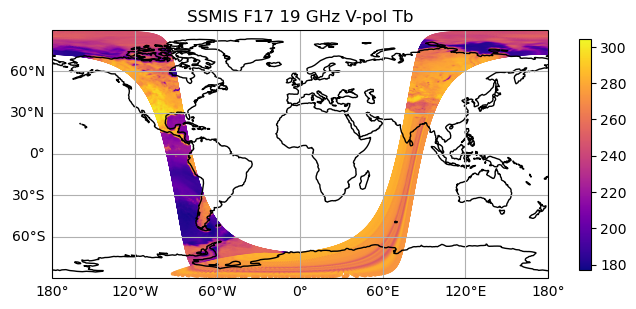

In [33]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], 
                data['lat'], 
                c=data['Tbs'][:,:,0], 
                transform=ccrs.PlateCarree(), 
                s=2.,
                cmap = 'plasma')
plt.colorbar(mappable=im, shrink=0.5)
plt.title('SSMIS F17 19 GHz V-pol Tb')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#ax.set_extent([-130,-120,40,57.5])
plt.show()

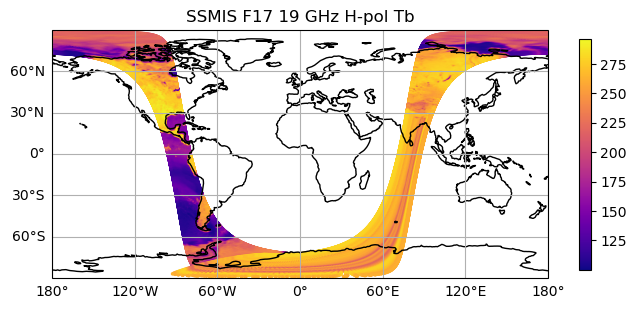

In [35]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], 
                data['lat'], 
                c=data['Tbs'][:,:,1], 
                transform=ccrs.PlateCarree(), 
                s=2.,
                cmap = 'plasma')
plt.colorbar(mappable=im, shrink=0.5)
plt.title('SSMIS F17 19 GHz H-pol Tb')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#ax.set_extent([-130,-120,40,57.5])
plt.show()

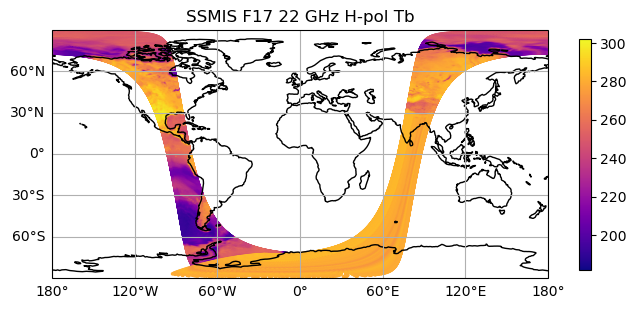

In [36]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], 
                data['lat'], 
                c=data['Tbs'][:,:,2], 
                transform=ccrs.PlateCarree(), 
                s=2.,
                cmap = 'plasma')
plt.colorbar(mappable=im, shrink=0.5)
plt.title('SSMIS F17 22 GHz H-pol Tb')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#ax.set_extent([-130,-120,40,57.5])
plt.show()

In [24]:
def get_prediction_error(lat, lon, Tbs, scantime, modelpath, sensor):
    
    good = ~np.isnan(lat)

    nscans, npixs, nchans = Tbs.shape
    scantime = local_functions.copy_columns(scantime, npixs)

    with cd(modelpath):
        #Load in model tree
        model_tree = model_operations.load_model_tree()
        #Attach GPM surface type
        sfctype = np.zeros([nscans,npixs], dtype=np.int32)
        sfctype[:] = -99
        sfctype[good] = local_functions.attach_gpm_sfctype(lat[good], 
                                                           lon[good],
                                                           scantime[good], 
                                                           sensor=sensor)
        #Do Tb prediction
        Tbs_pred = np.zeros_like(Tbs)
        Tbs_pred[:] = np.nan
        Tbs_pred[good] = model_operations.run_predictions(Tbs[good], 
                                                          sfctype[good], 
                                                          model_tree, 
                                                          keep_dims=False)

        #Load in stats files
        mean_ocn = np.fromfile('mean_ocn.arr', sep='', dtype=np.float32)
        std_ocn  = np.fromfile('std_ocn.arr', sep='', dtype=np.float32)
        mean_non = np.fromfile('mean_non.arr', sep='', dtype=np.float32)
        std_non  = np.fromfile('std_non.arr', sep='', dtype=np.float32)

    #Preallocate error array
    epsilon_hat = np.zeros_like(Tbs_pred)
    epsilon_hat[:] = np.nan

    #Separate by surface type
    ocean = sfctype == 1
    ocean = ocean.reshape(nscans,npixs)
    nonocean = sfctype > 1
    nonocean = nonocean.reshape(nscans,npixs)

    #Get error
    epsilon = Tbs - Tbs_pred
    #Standardize error
    epsilon_hat[ocean] = np.abs(epsilon[ocean] - mean_ocn) / std_ocn
    epsilon_hat[nonocean] = np.abs(epsilon[nonocean] - mean_non) / std_non
    
    return epsilon_hat

pred_err = get_prediction_error(data['lat'], 
                                data['lon'], 
                                data['Tbs'], 
                                data['scantime'], 
                                model_path, 
                                sensor='GMI')

In [26]:
error_threshold = 4
mlflag = np.zeros_like(data['Tbs'], dtype=np.int32)
mlflag[pred_err > error_threshold] = 1
mlflag[np.isnan(pred_err)] = -2

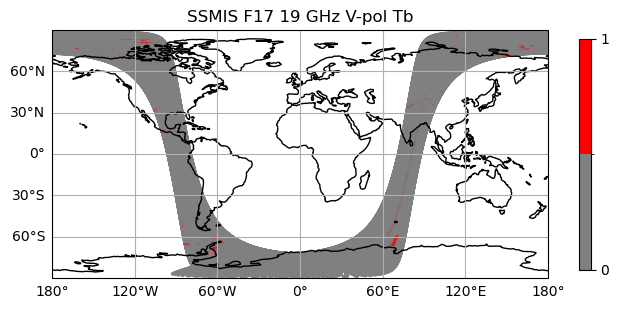

In [43]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = ListedColormap(["gray", "red"])
norm = BoundaryNorm([0, 0.5, 1], cmap.N)

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], 
                data['lat'], 
                c=mlflag[:,:,0], 
                transform=ccrs.PlateCarree(), 
                s=2.,
                cmap=cmap, norm=norm)
#plt.colorbar(mappable=im, shrink=0.5)
cbar = plt.colorbar(im, shrink=0.5, ticks=[0, 1])
cbar.ax.set_yticklabels(["0", "1"])
plt.title('SSMIS F17 19 GHz V-pol Tb')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#ax.set_extent([-130,-120,40,57.5])
plt.show()

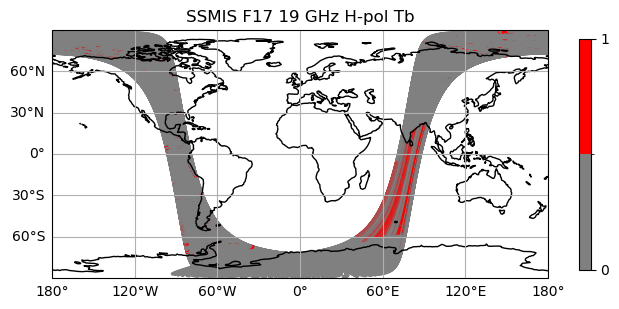

In [44]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], 
                data['lat'], 
                c=mlflag[:,:,1], 
                transform=ccrs.PlateCarree(), 
                s=2.,
                cmap=cmap, norm=norm)
cbar = plt.colorbar(im, shrink=0.5, ticks=[0, 1])
cbar.ax.set_yticklabels(["0", "1"])
plt.title('SSMIS F17 19 GHz H-pol Tb')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#ax.set_extent([-130,-120,40,57.5])
plt.show()

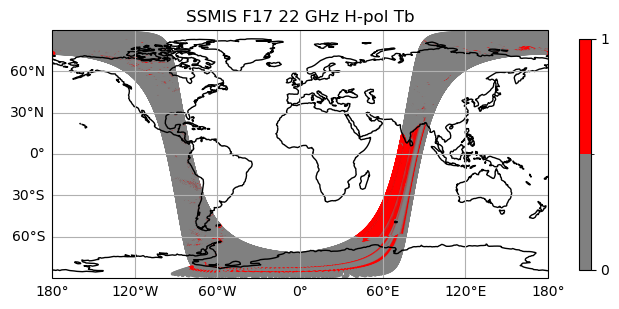

In [45]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], 
                data['lat'], 
                c=mlflag[:,:,2], 
                transform=ccrs.PlateCarree(), 
                s=2.,
                cmap=cmap, norm=norm)
cbar = plt.colorbar(im, shrink=0.5, ticks=[0, 1])
cbar.ax.set_yticklabels(["0", "1"])
plt.title('SSMIS F17 22 GHz H-pol Tb')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#ax.set_extent([-130,-120,40,57.5])
plt.show()

In [51]:
file = flist[1]
gnum = file.split('/')[-1].split('.')[-3]
l2a_file = glob.glob(f'/edata2/spencer/rfi_prediction/from_Jackson/2A-CLIM.F17.SSMIS.*.{gnum}.*.HDF5')[0]
l2a_file

'/edata2/spencer/rfi_prediction/from_Jackson/2A-CLIM.F17.SSMIS.GPROF2021v1.20150805-S233836-E012030.045156.V07A.HDF5'

In [67]:
with xr.open_dataset(l2a_file, group='S1', decode_timedelta=False) as f:
    prcp = f.surfacePrecipitation.values[:,::2]

prcp[prcp == 0] = np.nan

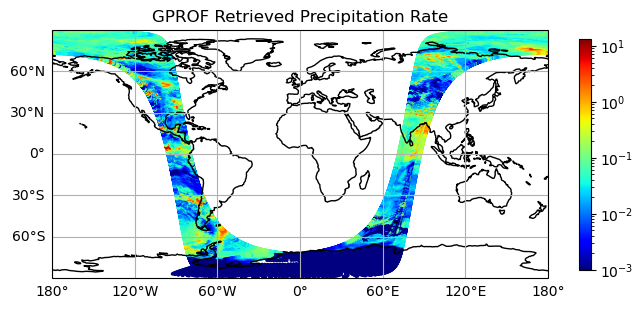

In [69]:
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], 
                data['lat'], 
                c=prcp, 
                transform=ccrs.PlateCarree(), 
                s=2., cmap='jet', norm=LogNorm(vmin=0.001))
#cbar = plt.colorbar(im, shrink=0.5, ticks=[0, 1])
#cbar.ax.set_yticklabels(["0", "1"])
plt.colorbar(im, shrink=0.5)
plt.title('GPROF Retrieved Precipitation Rate')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
#ax.set_extent([-130,-120,40,57.5])
plt.show()

In [59]:
prcp.shape, data['lat'].shape

((3510, 180), (3510, 90))